Goldfish of Solitude
A multimodal chat buddy for the elderly

Inspired by:

BERT Fine-Tuning Sentence Classification v2.ipynb

https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP#scrollTo=jw5K2A5Ko1RF



1. Using Colab GPU for training

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


2. Installing BERT Transformers (Hugging Face Library)

In [ ]:
!pip install transformers

3. Data exploration and prep for tensor conversion

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("data_train7934_test_clean_.csv", delimiter = ";", quoting=3, error_bad_lines=False) 
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df

Number of training sentences: 11,326



,Emotion,Text
0,neutral,There are tons of other paintings that I thin...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,"""This last may be a source of considerable dis..."
4,anger,She disliked the intimacy he showed towards so...
...,...,...
11321,sadness,"My sweetheart left me, or rather we decided to..."
11322,sadness,"Well , it's too bad that we like different kin..."
11323,neutral,It sure is .
11324,sadness,He's got laid off again . I do feel sorry for ...


In [ ]:
# Finding unique emotions to replace by Float
# to later be able to turn into tensors
df['Emotion'].unique()

array(['neutral', 'sadness', 'fear', 'anger', 'joy'], dtype=object)

In [ ]:
df.columns

Index(['Emotion', 'Text'], dtype='object')

In [ ]:
# Replace emotion by Float

def Emotion_to_numeric(a):
    if a == 'sadness':
        return 0
    if a == 'neutral':
        return 1
    if a == 'anger':
        return 2
    if a == 'fear':
        return 3
    if a == 'joy':
        return 4

df['emotion_num'] = df['Emotion'].apply(Emotion_to_numeric)


In [ ]:
# Get overview of names and emotion numbers 

print (df[['Emotion','emotion_num']].drop_duplicates(keep='first'))


   Emotion  emotion_num
0  neutral            1
1  sadness            0
2     fear            3
4    anger            2
6      joy            4


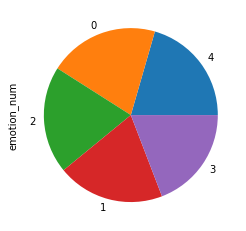

In [ ]:
# Check if data set is balanced
# It is balanced

df.emotion_num.value_counts().plot(kind='pie')

In [ ]:
# Get the lists of sentences and their labels
utterances = df.Text.values
emotions = df.emotion_num.values

4.  Preprocessing - BERT Tokeninzation

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
# Use BERT Base and from Bert Base the uncased model
tokenizer_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(tokenizer_name, do_lower_case=True) # we use the tokenizer from the pretrained model

Loading BERT tokenizer...


In [ ]:
# Demonstration that tokenization works
# Print the original sentence.
print(' Original: ', utterances[10])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(utterances[10]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(utterances[10])))


 Original:  I had gone to the hospital for my research and got late in reaching home.  I feared that when I reached home there would be a quarrel because of my being late.
Tokenized:  ['i', 'had', 'gone', 'to', 'the', 'hospital', 'for', 'my', 'research', 'and', 'got', 'late', 'in', 'reaching', 'home', '.', 'i', 'feared', 'that', 'when', 'i', 'reached', 'home', 'there', 'would', 'be', 'a', 'quarrel', 'because', 'of', 'my', 'being', 'late', '.']
Token IDs:  [1045, 2018, 2908, 2000, 1996, 2902, 2005, 2026, 2470, 1998, 2288, 2397, 1999, 4285, 2188, 1012, 1045, 8615, 2008, 2043, 1045, 2584, 2188, 2045, 2052, 2022, 1037, 26260, 2138, 1997, 2026, 2108, 2397, 1012]


5. Formatting 

Special tokens required: [SEP], {CLS] 

Sentence length: maximum sentence length is 512 tokens (MAX_LEN) 
training epochs take longer with longer MAX_LEN

Attention mask: attention mask = is an array of 1s or 0s to say which tokens are padding and which are not

tokenizer.encode combines 3 steps:

1. Split into tokens

2. Add [CLS] = 101 and [SEP] = 102 tokens

3. Map tokens to their IDs


It does not do padding however



5.1. Tokenize

In [ ]:
# Tokenize all utterances and map tokens to their word IDs

input_ids = []

# For every utterance:
for utt in utterances:
    encoded_sent = tokenizer.encode(
                        utt,                       # utterances to encode
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
# Add the encoded sentence to the list
    input_ids.append(encoded_sent)


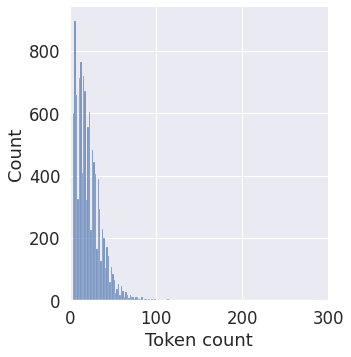

In [ ]:
# See histogram to view sentence length distribution

import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

token_lens = []

for txt in input_ids:
  token_lens.append(len(txt))

sns.set(font_scale=1.5)
sns.displot(token_lens)
plt.xlim([0, 300]);
plt.xlabel('Token count')
plt.show()

5.2. Padding and truncating

In [ ]:
# Finding MAX_LEN

print('Max sentence length: ', max([len(sen) for sen in input_ids]))

# Maximum sentence length train set = 277
# We don't know exactly whether and if so how much impact the padding has on the learning
# Increasing the padding size seems to have a negative impact (literature)
# but all the programs we have looked at do this
# We will first try to minimize padding size, while still taking a margin of three (3)
# [PAD]. Open question: what happens in production when inputs are longer than MAX_LEN?

Max sentence length:  277


In [ ]:
# Actual padding and truncating

from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 100

print('\nPadding/truncating all train sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad input tokens with value 0
# "post" indicates padding and truncation at the end of the sequence
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone')


Padding/truncating all train sentences to 100 values...

Padding token: "[PAD]", ID: 0

Done


5.3. Attention Masks

In [ ]:
# Create attention masks
attention_masks = []

# For each utterance...
for sent in input_ids:
    
# Create the attention mask.
    #   - If token ID is 0, then it is padding => set mask to 0
    #   - If token ID is > 0, then it is a real token => set mask to 1
    att_mask = [float(token_id > 0) for token_id in sent]
    
    # Store attention mask for utterance
    attention_masks.append(att_mask)

6. Train and validation set are different sets

In [ ]:
# Train/test split
# No shuffeling because this is on concatenated train and test set and the sets need to be kept separate
# Row 7934 starts the test set
# Train and test set want to be kept the same to be able to compare with Rebelo model
# Shuffeling would cause both train and test set to become unbalanced
# => No shuffeling

from sklearn.model_selection import train_test_split

# Training set and test set are split apart
shuffle_setting = False
train_inputs, validation_inputs, train_emotions, validation_emotions = train_test_split(input_ids, emotions, train_size = 7933, shuffle = shuffle_setting)
# Training masks and test masks are split apart
train_masks, validation_masks, _, _ = train_test_split(attention_masks, emotions, train_size = 7933, shuffle = shuffle_setting)

7. Converting to PyTorch data types (tensors)

When we represent data for machine learning, this generally needs to be done numerically. Especially when referring specifically of neural network data representation, this is accomplished via a data repository known as the tensor. A tensor is a container which can house data in N dimensions. Often and erroneously used interchangeably with the matrix (which is specifically a 2-dimensional tensor), tensors are generalizations of matrices to N-dimensional space.

Mathematically speaking, tensors are more than simply a data container, however. Aside from holding numeric data, tensors also include descriptions of the valid linear transformations between tensors. Examples of such transformations, or relations, include the cross product and the dot product. From a computer science perspective, it can be helpful to think of tensors as being objects in an object-oriented sense, as opposed to simply being a data structure.

From https://www.kdnuggets.com/2018/05/wtf-tensor.html

In [ ]:
# Convert all inputs and emotions into torch tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_emotions = torch.tensor(train_emotions)
validation_emotions = torch.tensor(validation_emotions)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

8. Create iterator for dataset

This helps to save memory during training

With a FOR loop the entire data set must be loaded into memory, with a data loader it does not

In [ ]:
# A data loader combines a dataset and a sampler, and provides an iterable over the given dataset
# The DataLoader needs to know batch size for training => we need to specify
# BERT creators recommend a batch size of 16 or 32 for finetuning BERT on a specific task
# Batch size 32 leads to faster training but lower accuracy
# Batch size will remain 16 for OPTIMISATION

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# Create DataLoader for training set
train_data = TensorDataset(train_inputs, train_masks, train_emotions)
train_sampler = RandomSampler(train_data) # the sampler is a random sampler to create more randomness in the sequence this helps to avoid overfitting
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for validation set
validation_data = TensorDataset(validation_inputs, validation_masks, validation_emotions)
validation_sampler = SequentialSampler(validation_data) # the sampler is a sequential sampler, randomization is not that important here
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

9. Train model (BertForSequenceClassification)

We use BERT Base (12-transformer layer model in stead of the 24-transformer layer full model) 

We use bert-base-uncased because we will be inputing STT text later on and there will be no casing (casing will not have significance)

In [ ]:
# Select pretrained "model" 
# BERT model can be changed for OPTIMISATION
from transformers import BertForSequenceClassification, AdamW, BertConfig

model_name = "bert-base-uncased"
 
model = BertForSequenceClassification.from_pretrained(
    model_name, # 12-layer BERT model, uncased vocabulary => can be changed for OPTIMISATION
    num_labels = 5, # number of output layers for classification   
    output_attentions = False, # model will not return attentions weights
    output_hidden_states = False, # model will return all hidden-states (change from False to True for getting hidden layer for model CONCATENATION)
)

# pytorch will run model on the GPU
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

10. Optimizer and learning rate scheduler

Optimizer: AdamW (W stands for Weight Decay Fix)

AdamW information: 
https://www.kdnuggets.com/2020/12/optimization-algorithms-neural-networks.html#:~:text=Optimizers%20are%20algorithms%20or%20methods,problems%20by%20minimizing%20the%20function. 

In the common weight decay implementation in the Adam optimizer the weight decay is implicitly bound to the learning rate. This means that when optimizing the learning rate you will also need to find a new optimal weight decay for each learning rate you try. The AdamW optimizer decouples the weight decay from the optimization step. This means that the weight decay and learning rate can be optimized separately, i.e. changing the learning rate does not change the optimal weight decay. The result of this fix is a substantially improved generalization performance.

https://towardsdatascience.com/why-adamw-matters-736223f31b5d 
https://www.fast.ai/2018/07/02/adam-weight-decay/ 
https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/ 



In [ ]:
# AdamW is from huggingface library (not Pytorch)
# lr = 3e-5 => args.learning_rate (we were told in class to take a very small learning rate) 
# Learning rate can be changed for OPTIMISATION purposes
# args.adam_epsilon => default value recommended by papers is 1e-8 for AdamW
# Epsilon value will not be changed for OPTMISATION

opt_learning_rate = 3e-5
opt_epsilon = 1e-8

optimizer = AdamW(model.parameters(),
                  lr = opt_learning_rate, 
                  eps = opt_epsilon
                  ) 

In [ ]:
from transformers import get_linear_schedule_with_warmup, get_constant_schedule_with_warmup, get_cosine_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4 - in class we were told between 3 and 5)
# Earlier runs show that the model starts overfitting already at the 3rd epoch
# Nr. of epochs can be changed - 2 seems to be enough for most hyperparameter settings (OPTIMISATION)

epochs = 4
sch_warmup_steps = 120

# Total number of training steps = number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
# Here linear scheduler. Creates a schedule with a learning rate that decreases linearly from the 
# initial lr set in the optimizer to 0, after a warmup period during which it increases linearly 

# For more schedulers: https://huggingface.co/transformers/main_classes/optimizer_schedules.html
'''scheduler_name = "get_linear_schedule_with_warmup"
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = sch_warmup_steps, # Default value in run_glue.py
                                            num_training_steps = total_steps)'''

scheduler_name = "get_cosine_schedule_with_warmup"
scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = sch_warmup_steps,
                                            num_training_steps = total_steps,
                                            num_cycles = 0.5)

'''scheduler_name = "get_constant_schedule_with_warmup"                                            
scheduler = get_constant_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = sch_warmup_steps)''' 


'scheduler_name = "get_constant_schedule_with_warmup"                                            \nscheduler = get_constant_schedule_with_warmup(optimizer, \n                                            num_warmup_steps = sch_warmup_steps)'

11. Training

In [ ]:
import numpy as np

# Function to calculate the accuracy of predictions vs emotions
def flat_accuracy(preds, emotions):
    pred_flat = np.argmax(preds, axis=1).flatten()
    emotions_flat = emotions.flatten()
    return np.sum(pred_flat == emotions_flat) / len(emotions_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    #Takes a time in seconds and returns a string hh:mm:ss
   
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
!pip install scikit-plot

In [ ]:
import scikitplot as skplt
import sklearn as sklearn
from sklearn import metrics



======== Epoch 1 / 4 ========
Training...
  Batch    40  of    248.    Elapsed: 0:00:39.
  Batch    80  of    248.    Elapsed: 0:01:19.
  Batch   120  of    248.    Elapsed: 0:01:59.
  Batch   160  of    248.    Elapsed: 0:02:39.
  Batch   200  of    248.    Elapsed: 0:03:19.
  Batch   240  of    248.    Elapsed: 0:03:59.

  Average training loss: 1.00
  Training epoch took: 0:04:07
  Accuracy: 0.61
              precision    recall  f1-score   support

           0    0.64911   0.55610   0.59901      1640
           1    0.71322   0.70792   0.71056      1616
           2    0.62333   0.50511   0.55802      1566
           3    0.47691   0.67828   0.56004      1492
           4    0.66275   0.62755   0.64467      1619

    accuracy                        0.61452      7933
   macro avg    0.62506   0.61499   0.61446      7933
weighted avg    0.62748   0.61452   0.61563      7933


Running Validation...
  Accuracy: 0.81
  Validation took: 0:00:38
[[462  24  94  66  30]
 [ 18 515  48  10

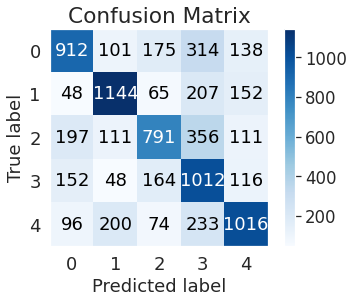

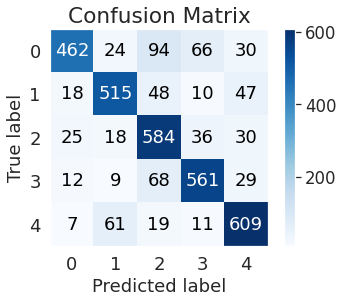

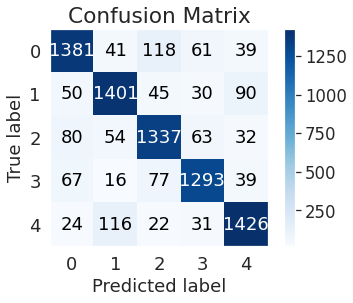

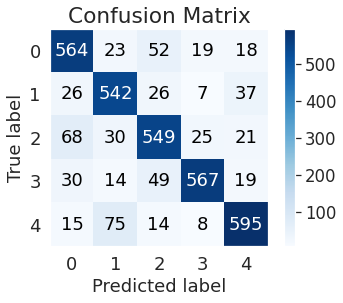

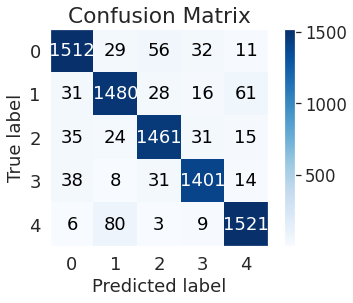

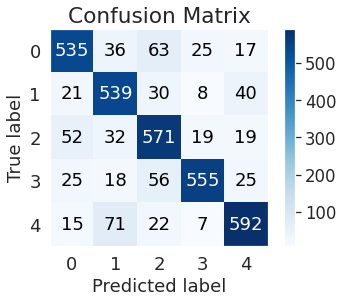

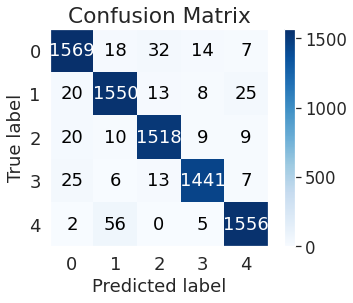

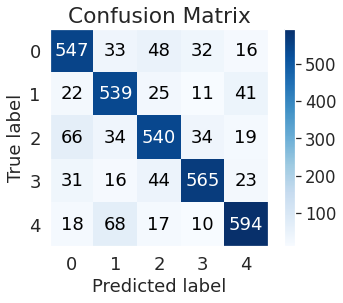

In [ ]:
import random
import os
import copy

# Training code based on `run_glue.py` script:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value to be able to start from the same seed value everywhere
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store average loss after each epoch for plot
loss_values = []
acc_train_values = []
acc_eval_values = []

# Log of learning rates
learning_rates_log = []

# Tracking training and evaluation for reporting
training_report_dict = None
evaluation_report_dict = None
max_validating_accuracy_epoch = 0
max_validation_accuracy = 0.0
max_training_report_dict = None
max_evaluation_report_dict = None

model.zero_grad()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # How long is training epoch
    t0 = time.time()

    # Reset the total loss for this epoch
    total_loss = 0

    # Put the model into training mode. 
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # Tracking variables 
    train_loss, train_accuracy = 0, 0
    nb_train_steps, nb_train_examples = 0, 0
    logits_all = []
    labels_all = []

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        learning_rates_log.append(scheduler.get_last_lr())
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack training batch from dataloader
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_emotions = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is convenient while training RNNs 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        # model.zero_grad() <<< outcommented here, because too early, must be berfore the backward pass, not the forward pass?       

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `emotions`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_emotions)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]
        logits = outputs[1]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        model.zero_grad()  
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)


        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_emotions.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of training sentences
        tmp_train_accuracy = flat_accuracy(logits, label_ids)
        logits_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        logits_all.extend(logits_flat)
        labels_all.extend(labels_flat)
        
        # Accumulate the total accuracy.
        train_accuracy += tmp_train_accuracy

        # Track the number of batches
        nb_train_steps += 1

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

        optimizer.zero_grad()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    # Report the final accuracy, precision, recall, F1 for this training run
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
    current_train_accuracy = train_accuracy/nb_train_steps # MEM
    acc_train_values.append(current_train_accuracy) # MEM
    print("  Accuracy: {0:.2f}".format(train_accuracy/nb_train_steps))
    skplt.metrics.plot_confusion_matrix(labels_all, logits_all)
    training_report_dict = metrics.classification_report(labels_all, logits_all, digits=5, output_dict=True)
    print(metrics.classification_report(labels_all, logits_all, digits=5)) 

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    logits_all = []
    labels_all = []

    # returns last layer [CLS] state (use for CONCAT)
    last_hidden_state = torch.Tensor()

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_emotions = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions
            # This will return the logits rather than the loss because we have
            # not provided labels
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_emotions.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        logits_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        logits_all.extend(logits_flat)
        labels_all.extend(labels_flat)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy, precision, recall, F1 for this validation run
    current_eval_accuracy = eval_accuracy/nb_eval_steps # For Accuracy CFR
    acc_eval_values.append(current_eval_accuracy) # For Accuracy CFR
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    skplt.metrics.plot_confusion_matrix(labels_all, logits_all)
    print(metrics.confusion_matrix(labels_all, logits_all))
    evaluation_report_dict = metrics.classification_report(labels_all, logits_all, digits=5, output_dict=True)
    print(metrics.classification_report(labels_all, logits_all, digits=5))

    # Storing maximum results in dictionary
    if evaluation_report_dict['accuracy'] > max_validation_accuracy:
      max_validation_accuracy = evaluation_report_dict['accuracy']
      max_validating_accuracy_epoch = epoch_i
      max_training_report_dict = copy.deepcopy(training_report_dict)
      max_evaluation_report_dict = copy.deepcopy(evaluation_report_dict)

    # for more info on precision, recall and F1 score:
    # https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1


    # Saving logits and labels as arrays and save to file (for CONCAT)
    # Load with logits_all = np.load("eval_logits.npy")
    # Load with labels_all = np.load("eval_labels.npy")
    logits_all = np.array(logits_all)
    np.save("eval_logits.npy", logits_all)
    labels_all = np.array(labels_all)
    np.save("eval_labels.npy", labels_all)

# Save the entire model + tokenizer to Colab
def save(model, tokenizer):
    output_dir = './output'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    print("Saving model to {}".format(output_dir))
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
save(model, tokenizer)

print("")
print("Training complete!")

In [ ]:
print (df[['Emotion','emotion_num']].drop_duplicates(keep='first'))

   Emotion  emotion_num
0  neutral            1
1  sadness            0
2     fear            3
4    anger            2
6      joy            4


12. Training loss over all batches

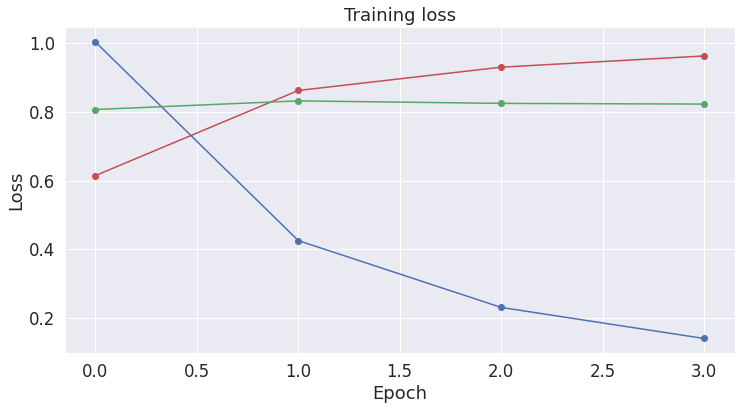

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')
plt.plot(acc_train_values, 'r-o') # addition for Accuracy CFR
plt.plot(acc_eval_values, 'g-o') # addition for Accuracy CFR
#plt.show() # addition for Accuracy CFR

# Label the plot.
plt.title("Training loss (B) train_acc (R) eval_acc (G)")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

Text(0.5, 1.0, 'Learning Rate')

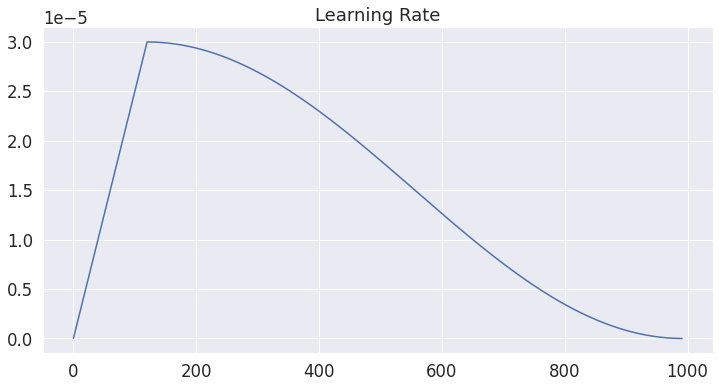

In [ ]:
# Effective learning rate plot
plt.plot(learning_rates_log,'b')
plt.title("Learning Rate per step")

In [ ]:
# print(learning_rates_log)

In [ ]:
# Output a final report for the parameters

now = datetime.datetime.now()
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")


print("################################################################################")
print("#                                                                              #")
print(f"#                     {dt_string}                                      #")
print("#                                                                              #")
print("################################################################################")

print(f"Model: {model_name}")
print(f"Tokenizer: {tokenizer_name}")
print(f"Padding: {MAX_LEN}")
print(f"Shuffle Data: {shuffle_setting}")
print(f"Batch Size: {batch_size}")
print(f"Data Loader: {type(train_sampler).__name__} / {type(validation_sampler).__name__}")
print(f"Optimizer: {type(optimizer).__name__}")
print(f"Learning Rate: {opt_learning_rate}")
print(f"Epsilon: {opt_epsilon}")
print(f"Epochs: {epochs}")
print(f"Scheduler: {scheduler_name}")
print(f"tr_acc: {max_training_report_dict['accuracy']:.2f}")
print(f"tr_precwa: {max_training_report_dict['weighted avg']['precision']:.2f}")
print(f"tr_precwa: {max_training_report_dict['weighted avg']['recall']:.2f}")
print(f"tr_precwa: {max_training_report_dict['weighted avg']['f1-score']:.2f}")
print(f"te_precwa: {max_evaluation_report_dict['weighted avg']['precision']:.2f}")
print(f"te_precwa: {max_evaluation_report_dict['weighted avg']['recall']:.2f}")
print(f"te_precwa: {max_evaluation_report_dict['weighted avg']['f1-score']:.2f}")
print(f"te_acc: {max_evaluation_report_dict['accuracy']:.2f}")
print(f"Warmup Steps: {sch_warmup_steps}")
print(f"Best epoch: {max_validating_accuracy_epoch+1}")

print(training_report_dict)
print(evaluation_report_dict)


print("####---Copy this line to the lab notebook---###")
print(f"{model_name}", end='\t')
print(f"{tokenizer_name}", end='\t')
print(f"{MAX_LEN}", end='\t')
print(f"{shuffle_setting}", end='\t')
print(f"{batch_size}", end='\t')
print(f"{type(train_sampler).__name__} / {type(validation_sampler).__name__}", end='\t')
print(f"{type(optimizer).__name__}", end='\t')
print(f"{opt_learning_rate}", end='\t')
print(f"{opt_epsilon}", end='\t')
print(f"{epochs}", end='\t')
print(f"{scheduler_name}", end='\t')
print(f"{max_training_report_dict['accuracy']:.2f}", end='\t')
print(f"{max_training_report_dict['weighted avg']['precision']:.4f}", end='\t')
print(f"{max_training_report_dict['weighted avg']['recall']:.4f}", end='\t')
print(f"{max_training_report_dict['weighted avg']['f1-score']:.4f}", end='\t')
print(f"{max_evaluation_report_dict['weighted avg']['precision']:.4f}", end='\t')
print(f"{max_evaluation_report_dict['weighted avg']['recall']:.4f}", end='\t')
print(f"{max_evaluation_report_dict['weighted avg']['f1-score']:.4f}", end='\t')
print(f"{max_evaluation_report_dict['accuracy']:.4f}", end='\t')
print(f"{sch_warmup_steps}", end='\t')
print(f"{max_validating_accuracy_epoch+1}")




################################################################################
#                                                                              #
#                     02/05/2021 12:55:18                                      #
#                                                                              #
################################################################################
Model: bert-base-uncased
Tokenizer: bert-base-uncased
Padding: 100
Shuffle Data: False
Batch Size: 32
Data Loader: RandomSampler / SequentialSampler
Optimizer: AdamW
Learning Rate: 3e-05
Epsilon: 1e-08
Epochs: 4
Scheduler: get_cosine_schedule_with_warmup
tr_acc: 0.86
tr_precwa: 0.86
tr_precwa: 0.86
tr_precwa: 0.86
te_precwa: 0.83
te_precwa: 0.83
te_precwa: 0.83
te_acc: 0.83
Warmup Steps: 120
Best epoch: 2
{'0': {'precision': 0.9590464547677262, 'recall': 0.9567073170731707, 'f1-score': 0.9578754578754579, 'support': 1640}, '1': {'precision': 0.9451219512195121, 'recall': 0.959158415841584